# 7章 報酬が {0, 1} の場合の問題

Author: hagino3000  
Date: 2016-11-30

「バンディット問題の理論とアルゴリズム」[1] の7章のアルゴリズムを実装して動かしてみる．

- LinUCB
- 線形モデル上のトンプソン抽出
- ロジスティック回帰モデル上のトンプソン抽出


[1] 「バンディット問題の理論とアルゴリズム」本多淳也／中村篤祥・著 http://www.kspub.co.jp/book/detail/1529175.html

## 実験データ

報酬はネット広告のクリック = {0, 1} ，μは2%前後 とする  
デザインとフォントは時刻tのコンテキスト(オーディエンス属性)に依存する，コンテキスト付きバンディット問題

In [2]:
# 報酬は {0, 1}
# 真の報酬モデル
campaigns = {
    'campaign_a': 0.05,
    'campaign_b': 0.10,
    'campaign_c': 0.22,
    'campaign_d': 0.15,
    'campaign_e': 0.13,
    'campaign_f': 0.09
}
attribute = {
    'men_20':    0.02,
    'men_30':    0.05,
    'female_20': 0.08,
    'female_30': 0.02  
}
# デザインとfontはユーザー属性に依存して報酬が決まる
contextual_attrs = {
    'men_20': {
        'design': {
            'a': 0.10,
            'b':-0.10,
            'c': 0.08,
            'd': 0.07
        },
        'font': {'a': 0.05, 'b': 0.1}
    },
    'men_30': {
        'design': {
            'a': 0.2,
            'b':-0.1,
            'c': 0.1,
            'd': 0.1
        },
        'font': {'a': 0.05, 'b': -0.08}
    },
    'female_20': {
        'design': {
            'a':-0.10,
            'b': 0.20,  
            'c': 0.15,
            'd': 0.08
        },
        'font': {'a': 0.05,'b': -0.01}
    }, 
    'female_30': {
        'design': {
            'a':-0.05,
            'b': 0.10, 
            'c': 0.07,
            'd': 0.05
        },
        'font': {'a': -0.05, 'b': 0.03}
    }
}

contextual_columns = []
contextual_values = []
for attr, attr_v in contextual_attrs.items():
    for el, el_v in attr_v.items():
        for type_name, value in el_v.items():
            contextual_columns.append(attr + '_' + el + '_' + type_name)
            contextual_values.append(value)

actions = []
for a in [campaigns.keys(), attribute.keys(), contextual_columns]:
    actions.extend(a)
theta = []
for a in [campaigns.values(), attribute.values(), contextual_values]:
    theta.extend(a)
theta = np.array(theta)

In [3]:
# actionの要素
print(actions)

['campaign_d', 'campaign_a', 'campaign_f', 'campaign_c', 'campaign_e', 'campaign_b', 'men_20', 'female_20', 'men_30', 'female_30', 'men_20_design_b', 'men_20_design_c', 'men_20_design_a', 'men_20_design_d', 'men_20_font_b', 'men_20_font_a', 'female_20_design_b', 'female_20_design_c', 'female_20_design_a', 'female_20_design_d', 'female_20_font_b', 'female_20_font_a', 'men_30_design_b', 'men_30_design_c', 'men_30_design_a', 'men_30_design_d', 'men_30_font_b', 'men_30_font_a', 'female_30_design_b', 'female_30_design_c', 'female_30_design_a', 'female_30_design_d', 'female_30_font_b', 'female_30_font_a']


In [4]:
print(theta)

[ 0.15  0.05  0.09  0.22  0.13  0.1   0.02  0.08  0.05  0.02 -0.1   0.08
  0.1   0.07  0.1   0.05  0.2   0.15 -0.1   0.08 -0.01  0.05 -0.1   0.1
  0.2   0.1  -0.08  0.05  0.1   0.07 -0.05  0.05  0.03 -0.05]


In [5]:
empty_row = {}
for c in actions:
    empty_row[c] = 0

In [6]:
print(empty_row)

{'female_30': 0, 'campaign_e': 0, 'men_30_font_b': 0, 'female_30_design_d': 0, 'men_30_design_d': 0, 'female_30_design_a': 0, 'men_30_font_a': 0, 'men_30_design_c': 0, 'female_30_design_b': 0, 'female_20_design_b': 0, 'female_20_design_d': 0, 'female_20_font_b': 0, 'men_30': 0, 'men_20_design_d': 0, 'female_20_design_c': 0, 'female_20_font_a': 0, 'female_30_font_b': 0, 'campaign_a': 0, 'campaign_f': 0, 'campaign_c': 0, 'men_20_design_c': 0, 'female_20': 0, 'campaign_d': 0, 'campaign_b': 0, 'men_20': 0, 'men_20_design_a': 0, 'men_20_font_a': 0, 'female_30_design_c': 0, 'men_30_design_a': 0, 'men_20_font_b': 0, 'men_30_design_b': 0, 'men_20_design_b': 0, 'female_30_font_a': 0, 'female_20_design_a': 0}


In [7]:
ret = []
for k, v in campaigns.items():
    cp = k
    cp_value = v
    for k, v in attribute.items():
        attr = k
        attr_value = v
        for k, v in contextual_attrs[attr]['design'].items():
            design = k
            design_value = v
            for k, v in contextual_attrs[attr]['font'].items():
                font = k
                font_value = v
                row = empty_row.copy()
                row[cp] = 1
                row[attr] = 1
                row[attr + '_design_' + design] = 1
                row[attr + '_font_' + font] = 1
                ret.append(row)

## 選択可能なactionの組み合わせ

In [8]:
df_actions = pd.DataFrame.from_dict(ret)
df_actions = df_actions[actions]
df_actions

,campaign_d,campaign_a,campaign_f,campaign_c,campaign_e,campaign_b,men_20,female_20,men_30,female_30,...,men_30_design_a,men_30_design_d,men_30_font_b,men_30_font_a,female_30_design_b,female_30_design_c,female_30_design_a,female_30_design_d,female_30_font_b,female_30_font_a
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# コンテキストの生成
contexts = [k for k in attribute.keys()]
def get_context(t):
    return contexts[t % len(contexts)]

In [10]:
# 0 or 1 の報酬を返す関数
bias = -4
def calc_reward_proba(action):
    exp_theta_T_action = np.exp(theta.dot(action) + bias)
    probability = exp_theta_T_action/(1 + exp_theta_T_action)
    return probability

def get_reward(action):
    return np.random.binomial(1, calc_reward_proba(action), 1)[0]

In [11]:
print('CTR for action 1 =', calc_reward_proba(df_actions.iloc[1].values))
print('CTR for action 2 =', calc_reward_proba(df_actions.iloc[2].values))
print('CTR for action 3 =', calc_reward_proba(df_actions.iloc[3].values))
print('CTR for action 4 =', calc_reward_proba(df_actions.iloc[4].values))

CTR for action 1 = 0.0202329970958
CTR for action 2 = 0.0253327032269
CTR for action 3 = 0.0241270214177
CTR for action 4 = 0.0258312385247


## LinUCB

118頁，アルゴリズム7.1

入力: 誤差項の分散 $\sigma^2$  
パラメータ: $\sigma_0^2, \alpha > 0$

$
A^{-1} \leftarrow \frac{\sigma^2_0}{\sigma^2}I_d.  \ //\ |a|*|a|の行列\\
b \leftarrow 0. \ //\ サイズ |a| のベクトル \\
\mathrm{for}\ t = 1,2,....,T\ \mathrm{do} \\
\hspace{10pt}\hat{\theta} \leftarrow A^{-1}b. \\
\hspace{10pt}//\ 各行動iについてUCBスコアの計算，ただし \alpha_t = \alpha\sqrt{logt} \\
\hspace{10pt}\overline{\mu_i} = a_{i,t}^{\mathrm{T}}\hat{\theta} + \alpha_t\sigma\sqrt{a_{i,t}^{\mathrm{T}}A^{-1}a_{i,t}}\\
\hspace{10pt}スコア最大の行動\ i\ \leftarrow\ argmax_i\overline{\mu_i}_(t) を選択して報酬 X(t) を観測 \\
\hspace{10pt}A^{-1} \leftarrow A^{-1} - \frac{A^{-1}a_{i,t}^{\mathrm{T}}A^{-1}}{1 + a_{i,t}^{\mathrm{T}}A^{-1}a_{i,t}}. \\
\hspace{10pt}b \leftarrow b + a_{i,t}X(t). \\
\mathrm{end\ for}
$

In [12]:
def calc_new_a_inv(A_inv, a_i_t):
    return A_inv - (A_inv*(np.matrix(a_i_t).T)*(a_i_t)*A_inv)/(1 + a_i_t.dot(A_inv).dot(a_i_t))

In [13]:
def linucb(T=1000, input_sigma2=600, param_sigma02=300, param_alpha=10):
    A_inv = np.matrix((param_sigma02/input_sigma2)*np.identity(len(actions)))
    b = np.zeros(len(theta))    

    # results
    rewards = []
    for t in range(1, T):
        alpha_t = param_alpha*np.sqrt(np.log(t))
        theta_hat = A_inv.A.dot(b)
        context = get_context(t)
        ucb_scores = []
        selectable_actions = []
        for i in df_actions[df_actions[context] != 0].index.values:
            a_i = df_actions.iloc[i].values
            ucb_score = a_i.dot(theta_hat) + alpha_t*np.sqrt(input_sigma2)*np.sqrt(a_i.dot(A_inv).dot(a_i))
            selectable_actions.append(a_i)
            ucb_scores.append(ucb_score)
        # 時刻tにおける行動 a_{i,t}
        a_i_t = selectable_actions[np.array(ucb_scores).argmax()]
        # 時刻tに観測した報酬
        reward = get_reward(a_i_t)
        b += a_i_t*reward
        A_inv = calc_new_a_inv(A_inv, a_i_t)
        rewards.append(reward)
    return theta_hat, np.array(rewards), b

In [14]:
theta_hat, rewards, b = linucb(T=100)

In [15]:
theta_hat

array([-0.00972502, -0.00908207, -0.00525717, -0.00565228, -0.00565228,
        0.04990327, -0.00132131,  0.01835125, -0.00117418, -0.00132131,
       -0.00033033, -0.00033033, -0.00033033, -0.00033033, -0.00097979,
       -0.00034152,  0.08573715, -0.02246196, -0.02246196, -0.02246196,
        0.04004373, -0.02169248, -0.00049585, -0.00049585, -0.00049585,
        0.00031338, -0.0008183 , -0.00035588, -0.00033033, -0.00033033,
       -0.00033033, -0.00033033, -0.00066066, -0.00066066])

In [16]:
b

array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [19]:
def run_linucb_test(T, trial, param_sigma02=0.01, param_alpha=10, plot=True):
    rewards_result = []
    loss_result = []
    for _ in range(trial):
        theta_hat, rewards, b = linucb(T=T, param_sigma02=param_sigma02, param_alpha=param_alpha)
        loss = sum(theta - theta_hat)
        rewards_result.append(rewards.cumsum())
        loss_result.append(loss)
    
    reward_gained_mean = np.array(rewards_result).mean(axis=0)
    if plot:
        plt.figure(figsize=(14, 2))
        plt.xlabel('time')
        plt.ylabel('Average Rewards')
        plt.plot(reward_gained_mean)
    print('Theta - ThetaHat:{}'.format(np.mean(loss_result)))
    return reward_gained_mean

Theta - ThetaHat:1.9998601400832263


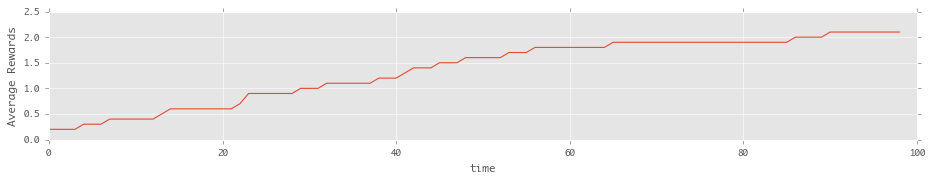

In [20]:
rewards = run_linucb_test(T=100, trial=10)

## パラメータチューニング

In [307]:
rewards_1 = run_linucb_test(T=100, trial=10, param_alpha=0.5, plot=False)
rewards_2 = run_linucb_test(T=100, trial=10, param_alpha=1, plot=False)
rewards_3 = run_linucb_test(T=100, trial=10, param_alpha=10, plot=False)

Theta - ThetaHat:35.19394641847836
Theta - ThetaHat:27.671827014776312
Theta - ThetaHat:1.5365711981713441


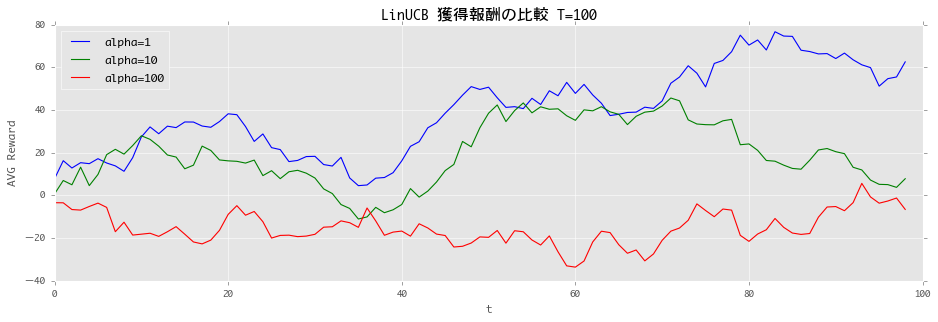

In [308]:
plt.figure(figsize=(14, 4))
plt.plot(rewards_1, color='b', label='alpha=1')
plt.plot(rewards_2, color='g', label='alpha=10')
plt.plot(rewards_3, color='r', label='alpha=100')
plt.ylabel('AVG Reward')
plt.xlabel('t')
plt.legend(loc='best')
plt.title(u'LinUCB 獲得報酬の比較 T=100')

# 正規分布モデルのThompson抽出

121頁, アルゴリズム7.2

入力: 誤差項の分散 $\sigma^2$  
パラメータ: $\sigma_0^2 > 0$

$
A^{-1} \leftarrow \frac{\sigma^2_0}{\sigma^2}I_d.  \ //\ |a|*|a|の行列\\
b \leftarrow 0. \ //\ サイズ |a| のベクトル \\
\mathrm{for}\ t = 1,2,....,T\ \mathrm{do} \\
\hspace{10pt}\tilde{\theta}\ を多変量正規分布\ N(A^{-1}b, \sigma^2A^{-1})\ から生成. \\
\hspace{10pt}i \leftarrow argmax_i\tilde{\theta}^{\mathrm{T}}_a{i,t} を選択して報酬 X(t) を観測. \\
\hspace{10pt}A^{-1} \leftarrow A^{-1} - \frac{A^{-1}a_{i,t}^{\mathrm{T}}A^{-1}}{1 + a_{i,t}^{\mathrm{T}}A^{-1}a_{i,t}}. \\
\hspace{10pt}b \leftarrow b + a_{i,t}X(t). \\
\mathrm{end\ for}
$

In [31]:
def thompson_sampling(T=1000, input_sigma2=600, param_sigma02=300):
    A_inv = np.matrix((param_sigma02/input_sigma2)*np.identity(len(actions)))
    b = np.zeros(len(theta))

    # results
    rewards = []
    for t in range(1, T):
        theta_hat = np.random.multivariate_normal(A_inv.A.dot(b), input_sigma2*A_inv)
        context = get_context(t)
        estimated_rewards = []
        selectable_actions = []
        for i in df_actions[df_actions[context] != 0].index.values:
            a_i = df_actions.iloc[i].values
            estimated_reward = a_i.T.dot(theta_hat)
            selectable_actions.append(a_i)
            estimated_rewards.append(estimated_reward)
        # 時刻tにおける行動 a_{i,t}
        a_i_t = selectable_actions[np.array(estimated_rewards).argmax()]
        # 時刻tに観測した報酬
        reward = get_reward(a_i_t)
        b += a_i_t*reward
        A_inv = calc_new_a_inv(A_inv, a_i_t)
        rewards.append(reward)
    return theta_hat, np.array(rewards), b

In [32]:
def run_thompson_test(T, trial, param_sigma02=300, plot=True):
    rewards_result = []
    loss_result = []
    for _ in range(trial):
        theta_hat, rewards, b = thompson_sampling(T=T, param_sigma02=param_sigma02)
        loss = sum(theta - theta_hat)
        rewards_result.append(rewards.cumsum())
        loss_result.append(loss)
    
    reward_gained_mean = np.array(rewards_result).mean(axis=0)
    if plot:
        plt.figure(figsize=(14, 2))
        plt.xlabel('time')
        plt.ylabel('Average Rewards')
        plt.plot(reward_gained_mean)
    print('Theta - ThetaHat:{}'.format(np.mean(loss_result)))
    return reward_gained_mean

In [33]:
# T=50でテスト
theta_hat, rewards, b = thompson_sampling(50)

In [34]:
# 全ての項から報酬が発生している (選択した) 事を確認
b

array([  276.75770051,   640.8336134 ,  1431.75158259,   119.38254037,
         279.76070213,   116.32181901,   908.46536504,   502.53048781,
         769.37346435,   684.4386408 ,   187.54588158,   720.91948346,
         438.73116332,    77.43749078,   218.63819751,   173.65851344,
         158.58822875,   343.94225906,    78.65060871,   192.87717325,
         131.56012401,    99.44258183,   160.90942147,   608.46404288,
         664.39696363,    -7.33949767,    43.55180232,    68.76419607,
         636.03280308,    48.40583772,   604.24721544,     0.        ,
          80.19142537,     0.        ])

In [35]:
# t=50時点での\theta_hat
theta_hat

array([ 14.89104079,   9.98288086,  39.02654801,  12.26610961,
        15.81549193,   7.12687678,  13.34098105,  19.72116618,
        -7.05812311,  -0.16406125,  17.62318165,  34.6569711 ,
         2.30721887,  26.81998031,   8.9114044 ,  13.97492435,
        10.27118992,  13.48540512,   3.39713531, -31.64226081,
        -9.68064504,   1.62785939, -10.22228795,  25.8726178 ,
        43.99529959,  18.75842974,   1.72792461,  15.4884568 ,
        11.3224804 ,  -3.55637606,  21.0103688 ,  16.5966572 ,
        -7.28330742, -30.54331565])

Theta - ThetaHat:231.3591977104765


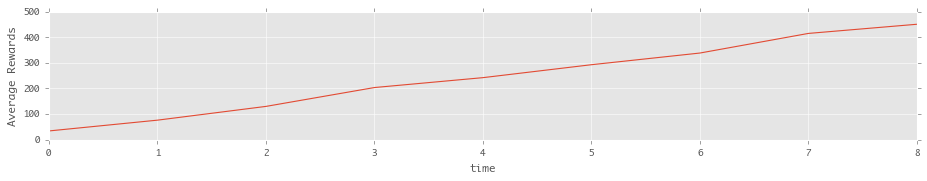

In [36]:
rewards_result = run_thompson_test(T=10, trial=20)

Theta - ThetaHat:99.4002301867977


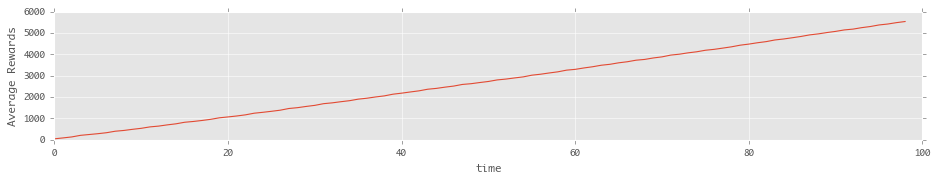

In [37]:
rewards_result = run_thompson_test(T=100, trial=20)

Theta - ThetaHat:51.86317058535004


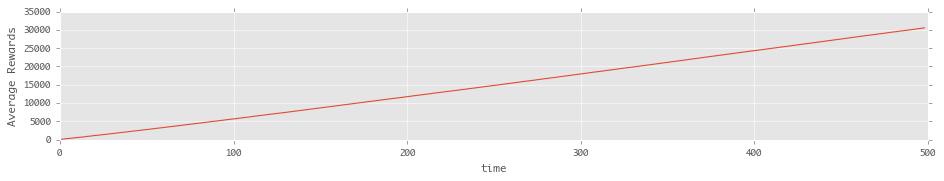

In [38]:
rewards_result = run_thompson_test(T=500, trial=20)

## パラメータチューニング

In [39]:
rewards_1 = run_thompson_test(T=100, trial=10, param_sigma02=50, plot=False)
rewards_2 = run_thompson_test(T=100, trial=10, param_sigma02=300, plot=False)
rewards_3 = run_thompson_test(T=100, trial=10, param_sigma02=2000, plot=False)

Theta - ThetaHat:205.43614903993247
Theta - ThetaHat:89.13679088591508
Theta - ThetaHat:76.06030947826324


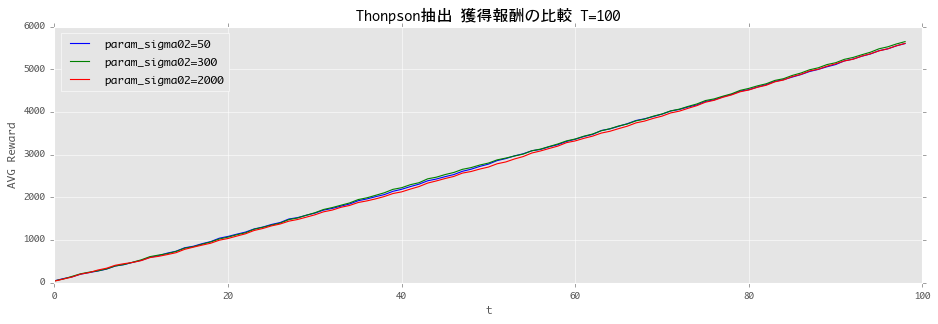

In [40]:
plt.figure(figsize=(14, 4))
plt.plot(rewards_1, color='b', label='param_sigma02=50')
plt.plot(rewards_2, color='g', label='param_sigma02=300')
plt.plot(rewards_3, color='r', label='param_sigma02=2000')
plt.ylabel('AVG Reward')
plt.xlabel('t')
plt.legend(loc='best')
plt.title(u'Thonpson抽出 獲得報酬の比較 T=100')

## 比較用のepsilon greedy実装

In [41]:
def epsilon_greedy(T=1000, epsilon=0.1):
    # results
    rewards = []
    selected_counts = np.zeros(len(df_actions))
    gained_rewards = np.zeros(len(df_actions))
    for t in range(1, T):
        context = get_context(t)
        estimated_rewards = []
        selectable_actions = []
        selectable_actions_idx = []
        for i in df_actions[df_actions[context] != 0].index.values:
            a_i = df_actions.iloc[i].values
            estimated_reward = gained_rewards[i]/selected_counts[i]
            selectable_actions.append(a_i)
            selectable_actions_idx.append(i)
            estimated_rewards.append(estimated_reward)
        # 時刻tにおける行動 a_{i,t}
        if np.random.rand() > epsilon:
            _idx = np.array(estimated_rewards).argmax()
        else:
            # 探索
            _idx = np.random.randint(len(selectable_actions))
        a_i_t = selectable_actions[_idx]
        action_idx = selectable_actions_idx[_idx]
        # 時刻tに観測した報酬
        reward = get_reward(a_i_t)
        rewards.append(reward)
        selected_counts[action_idx] += 1
        gained_rewards[action_idx] += reward

    return np.array(rewards), selected_counts

In [42]:
def run_epsilon_greedy_test(T, trial, plot=True):
    rewards_result = []
    selected_counts_result = []
    for _ in range(trial):
        rewards, selected_counts = epsilon_greedy(T=T)
        rewards_result.append(rewards.cumsum())
        selected_counts_result.append(selected_counts)
    
    reward_gained_mean = np.array(rewards_result).mean(axis=0)
    selected_count_mean = np.array(selected_counts_result).mean(axis=0)
    if plot:
        plt.figure(figsize=(14, 2))
        plt.xlabel('time')
        plt.ylabel('Average Rewards')
        plt.plot(reward_gained_mean)
    return reward_gained_mean, selected_count_mean

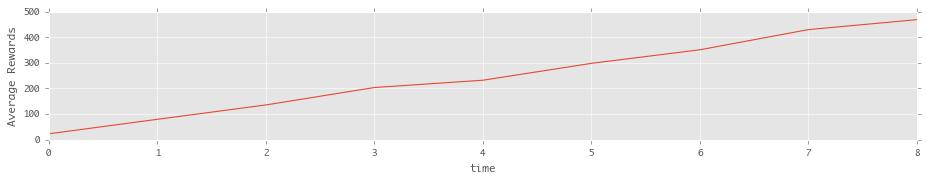

In [43]:
_, selected_count = run_epsilon_greedy_test(10, trial=20, plot=True)

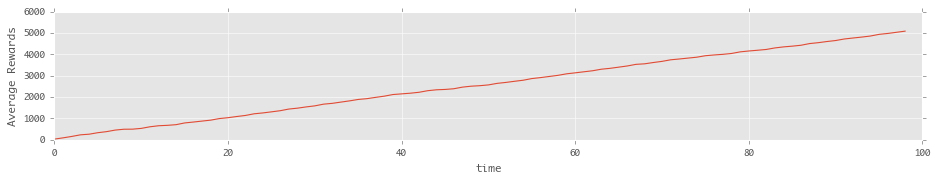

In [44]:
_, selected_count = run_epsilon_greedy_test(100, trial=20, plot=True)

In [45]:
selected_count

array([ 1.05,  1.  ,  1.  ,  1.1 ,  1.1 ,  1.05,  1.05,  1.  ,  1.  ,
        1.05,  1.  ,  1.05,  1.1 ,  1.  ,  1.05,  1.05,  1.  ,  1.05,
        1.1 ,  1.05,  1.1 ,  1.1 ,  1.05,  1.1 ,  1.  ,  1.15,  1.  ,
        1.  ,  1.  ,  1.05,  1.  ,  1.05,  1.05,  1.  ,  1.05,  1.  ,
        1.05,  1.  ,  1.05,  1.  ,  1.  ,  1.  ,  1.05,  1.05,  1.05,
        1.05,  1.  ,  1.05,  1.  ,  1.  ,  1.  ,  1.  ,  1.05,  1.  ,
        1.  ,  1.  ,  1.05,  1.  ,  1.  ,  1.  ,  1.05,  1.05,  1.  ,
        1.  ,  1.05,  1.  ,  1.  ,  1.  ,  1.  ,  0.75,  0.55,  0.25,
        1.  ,  1.05,  1.  ,  1.  ,  1.05,  1.  ,  0.9 ,  0.45,  1.05,
        1.  ,  1.  ,  1.05,  1.  ,  0.95,  0.8 ,  0.45,  1.05,  1.  ,
        1.  ,  1.  ,  0.95,  0.95,  0.75,  0.65,  0.05,  0.05,  0.  ,
        0.05,  0.  ,  0.  ,  0.05,  0.  ,  0.25,  0.1 ,  0.05,  0.  ,
        0.05,  0.  ,  0.  ,  0.  ,  0.15,  0.  ,  0.05,  0.05,  0.1 ,
        0.05,  0.05,  0.  ,  0.15,  0.  ,  0.  ,  0.  ,  0.15,  0.  ,
        0.05,  0.  ,

## 比較

In [46]:
# T=100
T=100
trial=10
result_ep, selected_ep = run_epsilon_greedy_test(T=T, trial=trial, plot=False)
result_ucb = run_linucb_test(T=T, trial=trial, param_alpha=1, plot=False)
result_thompson = run_thompson_test(T=T, trial=trial, plot=False)

Theta - ThetaHat:235.89946124588693
Theta - ThetaHat:107.09071782121285


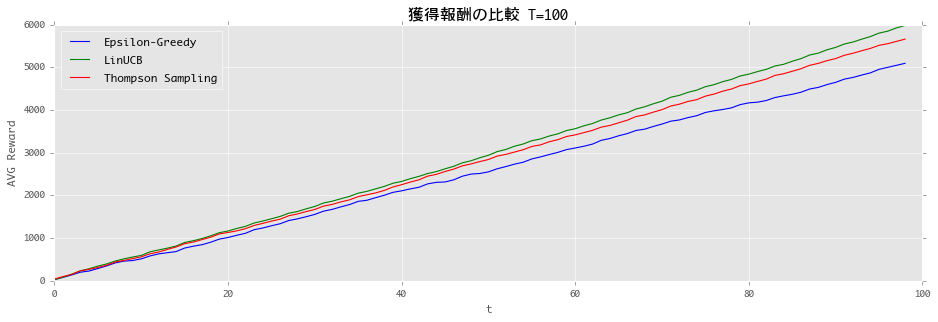

In [47]:
plt.figure(figsize=(14, 4))
plt.plot(result_ep, color='b', label='Epsilon-Greedy')
plt.plot(result_ucb, color='g', label='LinUCB')
plt.plot(result_thompson, color='r', label='Thompson Sampling')
plt.ylabel('AVG Reward')
plt.xlabel('t')
plt.legend(loc='best')
plt.title(u'獲得報酬の比較 T=100')

In [48]:
# T=500
T=500
trial=10
result_ep, selected_ep = run_epsilon_greedy_test(T=T, trial=trial, plot=False)
result_ucb = run_linucb_test(T=T, trial=trial, param_alpha=1, plot=False)
result_thompson = run_thompson_test(T=T, trial=trial, plot=False)

Theta - ThetaHat:80.38242017314778
Theta - ThetaHat:58.569309858744745


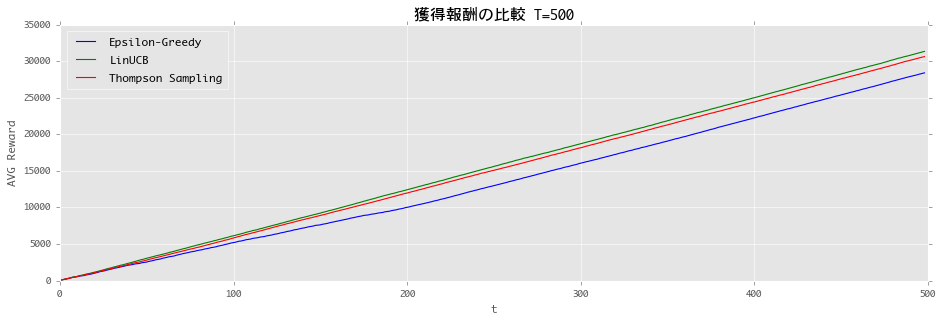

In [49]:
plt.figure(figsize=(14, 4))
plt.plot(result_ep, color='b', label='Epsilon-Greedy')
plt.plot(result_ucb, color='g', label='LinUCB')
plt.plot(result_thompson, color='r', label='Thompson Sampling')
plt.ylabel('AVG Reward')
plt.xlabel('t')
plt.legend(loc='best')
plt.title(u'獲得報酬の比較 T=500')

## ロジスティック回帰モデル上のトンプソン抽出

0 or 1の報酬が返るような環境を作る．広告のクリック率を想定してCTR1〜2%程度とする

125頁，アルゴリズム7.3

In [264]:
def calc_gradient(theta, var, action_history):
    ret = []
    ret.append(theta/var)

    for action_i_s, reward in action_history:
        exp_theta_T_action_i_s = np.exp(theta.dot(action_i_s))
        ret.append((exp_theta_T_action_i_s*action_i_s)/(1 + exp_theta_T_action_i_s))

    for action_i_s, reward in action_history:
        if reward == 1:
            ret.append(action_i_s * -1)
    return np.array(ret).sum(axis=0)

In [299]:
def calc_hessian(theta, var, action_history):
    ret = []
    ret.append(np.identity(len(actions))/var)

    for action_i_s, reward in action_history:
        exp_theta_T_action_i_s = np.exp(theta.dot(action_i_s))
        ret.append((exp_theta_T_action_i_s*(np.matrix(action_i_s).T)*action_i_s)/(1+exp_theta_T_action_i_s)**2)

    return np.array(ret).sum(axis=0)

In [333]:
def calc_theta_hat(theta_hat, var, action_history, traial=20):
    _theta_hat = theta_hat
    for _ in range(traial):
        hessian = calc_hessian(_theta_hat, 2, action_history)
        gradient = calc_gradient(_theta_hat, 2, action_history)
        _theta_hat = _theta_hat - np.linalg.inv(hessian).dot(gradient)
    return _theta_hat

In [360]:
def thompson_sampling_on_logistic_regression(T=1000, param_sigma02=0.01):
    rewards = []
    action_history = []
    selected_counts = np.zeros(len(df_actions))
    theta_hat = np.zeros(len(actions))
    for t in range(1, T):
        if t % 10 == 1:
            theta_hat = calc_theta_hat(theta_hat, param_sigma02, action_history)
            hessian = calc_hessian(theta_hat, param_sigma02, action_history)
        theta_tild = np.random.multivariate_normal(
            theta_hat,
            np.linalg.inv(hessian)
        )
        context = get_context(t)
        estimated_rewards = []
        selectable_actions = []
        selectable_action_idx = []
        for i in df_actions[df_actions[context] != 0].index.values:
            a_i = df_actions.iloc[i].values
            selectable_actions.append(a_i)
            selectable_action_idx.append(i)
            estimated_rewards.append(a_i.T.dot(theta_tild))
        # 時刻tにおける行動 a_{i,t}
        argmax_i = np.array(estimated_rewards).argmax()
        a_i_t = selectable_actions[argmax_i]
        selected_i = selectable_action_idx[argmax_i]
        # 時刻tに観測した報酬
        reward = get_binary_reward(a_i_t)
        action_history.append((a_i_t, reward))
        rewards.append(reward)
        selected_counts[selected_i] += 1
    return theta_hat, np.array(rewards), selected_counts

In [361]:
def run_thompson_sampling_on_logistic_regression_test(T, trial, param_sigma02=0.01, plot=True):
    rewards_result = []
    selected_counts_result = []
    for _ in range(trial):
        theta_hat, rewards, selected_counts = thompson_sampling_on_logistic_regression(T=T)
        rewards_result.append(rewards.cumsum())
        selected_counts_result.append(selected_counts)
    
    reward_gained_mean = np.array(rewards_result).mean(axis=0)
    selected_count_mean = np.array(selected_counts_result).mean(axis=0)
    if plot:
        plt.figure(figsize=(14, 2))
        plt.xlabel('time')
        plt.ylabel('Average Rewards')
        plt.plot(reward_gained_mean)
    return reward_gained_mean, selected_count_mean

(array([  0. ,   0. ,   0. , ...,  36.6,  36.6,  36.6]),
 array([ 14. ,   8.4,   9.3,   5.9,  14.6,   8.8,  12.5,   9. ,   8.1,
         11.1,  10.4,  15. ,   9.9,  11.8,   7.5,   7.6,   8.4,   8.9,
         10.3,  14.5,   8.6,   9.4,  10.3,   8.7,   7.6,  11.8,   6.4,
         13.6,  10.2,  11.9,  11.1,  12.6,  11. ,   9.8,   7.5,   7.1,
          8.9,   7.8,   8.3,   6.7,   6.1,   8.9,   9.4,  10.6,   7.5,
         10.2,   6.3,   8. ,   5.7,   7.7,   8.2,  12. ,   6.7,   8.6,
          8.9,   9.1,   6.3,   7.6,   7.1,  10.9,   6.9,  12.2,   9.3,
          9.5,  12.3,  11.1,   7.7,   6.3,  13.8,   9.5,  10.2,  10.1,
          9.1,  11.8,  11.4,  13.2,  11.5,  12.1,   6.6,   8.1,   7.2,
         10.2,  12.9,  15.8,   9.9,  10.6,  10.5,  12.2,   7.7,   9.6,
          8.4,  11. ,  10.1,  11.9,   9.5,  12. ,  11.5,  10.6,   7.2,
          6.1,  12.1,   8.5,   9.9,   9.2,   9.8,  10.3,   9.1,  12.3,
          8.9,  12.6,   7.1,   8.5,   7.6,   7.5,  11.7,  11.8,   7.8,
          8.9,   8.3

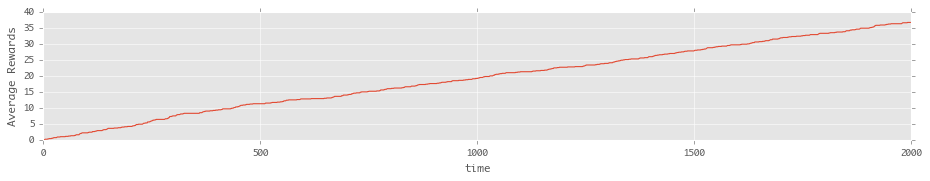

In [358]:
rewards, selected_count = run_thompson_sampling_on_logistic_regression_test(2000, 10, param_sigma02=0.01)